<a href="https://colab.research.google.com/github/fjme95/python-para-la-ciencia-de-datos/blob/main/Semana%209/An%C3%A1lisis_de_Supervivencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
%%capture
!pip install lifelines -U plotly

In [ ]:
# Manejo de datos
import pandas as pd
import numpy as np

# Análisis de supervivencia
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
# Visualización
from lifelines.plotting import add_at_risk_counts

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly.express as px
import plotly.io as pio

In [ ]:
pio.templates.default = 'plotly_white'

# Datos

Trabajaremos con los datos de [Heart Failure Prediction](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data).

## Descripción de los datos



> Las enfermedades cardiovasculares (ECVs) son la causa número 1 de muertes en el mundo, tomando un estimado de 17.9 millones de vidas cada año, el 31% de las muertes globalmente.
La insuficiencia cardiaca es un evento común causado por las ECVs y este conjunto de datos tiene 12 características que pueden ser usadas para predecir la mortalidad por insuficiencia cardiaca.

> La mayoría de las enfermedades cardiacas se pueden prevenir abordando factores de riesgo conductuales, como el tabaquismo, dieta poco saludable y la obesidad, inactividad física y el consumo nocivo del alcohol, mediante estrategias que abarquen toda las población.

> Las personas con enfermedades cardiovasculares o con alto riesgo cardiovascular (por la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan una detección y manejo temprano en el que un modelo de aprendizaje automático puede ser de gran ayuda.



##Columnas



- **age**: Edad
- **anaemia**: Disminución de glóbulos rojos o hemoglobina (booleano)
- **creatinine_phosphokinase**: Nivel de la enzima CPK en la sangre (mcg/L)
- **diabetes**: Si el paciente tiene diabetes (booleano)
- **ejection_fraction**: Porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- **high_blood_pressure**: Si el paciente tiene hipertensión (booleano)
- **platelets**: Plaquetas en la sangre (kiloplaquetas/mL)
- **serum_creatinine**: Nivel de creatinina sérica en la sangre (mg/dL)
- **serum_sodium**: Nivel de sodio sérico en la sangre (mEq/L)
- **sex**: Mujer u hombre (binario)
- **smoking**: Si el paciente fuma o no (booleano)
- **time**: Período de seguimiento (días)
- **DEATH_EVENT**: Si el paciente falleció durante el período de seguimiento (booleano)



## Lectura


In [ ]:
heart_data_raw = pd.read_csv('https://raw.githubusercontent.com/fjme95/python-para-la-ciencia-de-datos/dev/Semana%209/data/heart_failure_clinical_records_dataset.csv')

In [ ]:
heart_data_raw

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Exploración

In [ ]:
px.histogram(heart_data_raw, 'age', title = 'Histograma de la edad')

In [ ]:
px.histogram(heart_data_raw, 'age', color='smoking', barmode='group')

In [ ]:
# px.parallel_categories(heart_data_raw[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']], color = 'DEATH_EVENT', color_continuous_scale=px.colors.sequential.Blugrn)

¿Qué le gustaría saber de los datos durante la fase exploratoria?

# Kaplan-Meier

El estimador de Kapan-Meier es una estadística no paramétrica usada para estimar la función de supervivencia de *datos de vida*.

El estimador para la función de supervivencia $S(t)$ (la probabilidad de que sobreviva más de $t$) viene dada por:

$$
\hat{S}(t) = \prod_{i: t_i \leq t}\left(1-\frac{d_i}{n_i}\right), 
$$

con $t_i$ el tiempo cuando paso un evento, $d_i$ el número de eventos (e.g. muertes) que pasaron al tiempo $t_i$, y $n_i$ el número de individuos que se sabe han sobrevivido (que no han tenido el evento o ni han sido censurados) hasta el tiempo $t_i$.

Al ser una estadística, existen varios estimadores para su varianza. Uno de los más comunes es el de Greenwood:

$$
\hat{Var}\left(\hat{S}\left(t\right)\right) = \hat{S}\left(t\right)^2\sum_{i: t_i \leq t}\frac{d_i}{n_i\left(n_i - d_i\right)}
$$

En la libreria ```lifelines``` que ocuparemos en este notebook.

## Ajuste


In [ ]:
T = heart_data_raw.time
E = heart_data_raw.DEATH_EVENT

model = KaplanMeierFitter()

model.fit(T, event_observed = E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 299 total observations, 203 right-censored observations>

## Tabla de eventos

In [ ]:
model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,299,299
4.0,1,1,0,0,299
6.0,1,1,0,0,298
7.0,2,2,0,0,297
8.0,2,2,0,0,295
...,...,...,...,...,...
270.0,2,0,2,0,6
271.0,1,0,1,0,4
278.0,1,0,1,0,3


## Visualización de la estimación

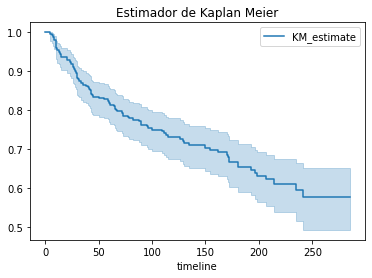

In [ ]:
model.plot_survival_function(title = 'Estimador de Kaplan Meier')

# Comparando curvas de supervivencia

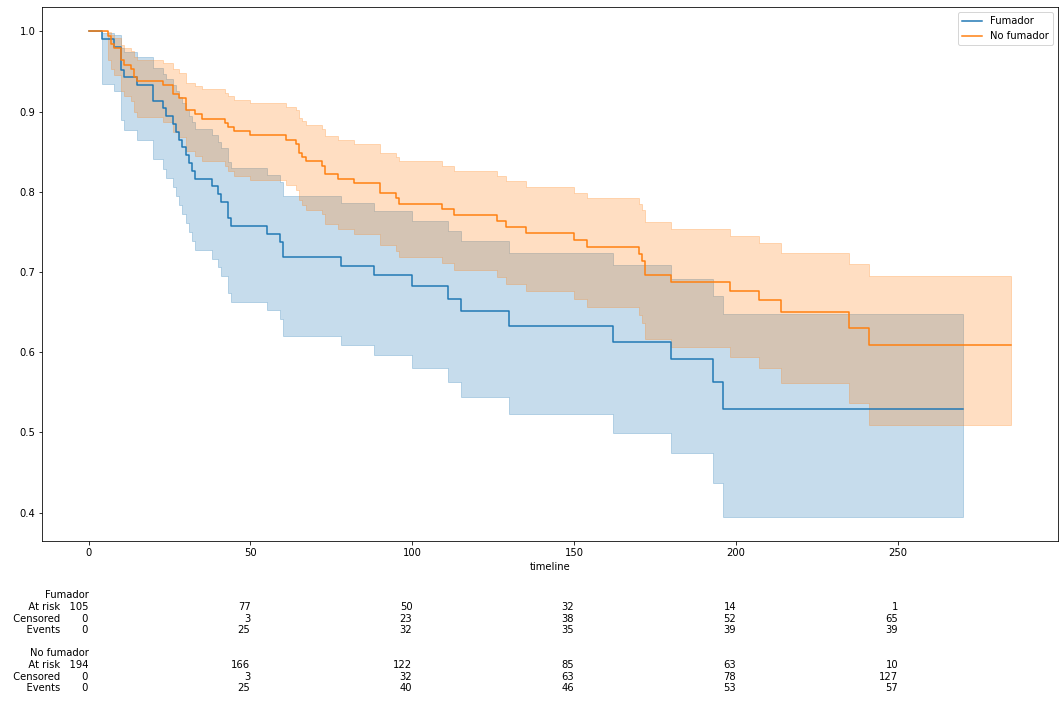

In [ ]:
hbp_mask = (heart_data_raw['high_blood_pressure'] == 1)

T = heart_data_raw.time
E = heart_data_raw.DEATH_EVENT

fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)

kmf_hbp = KaplanMeierFitter()
ax = kmf_fumador.fit(T[hbp_mask], event_observed=E[hbp_mask], label='Presión alta').plot_survival_function(ax = ax)


kmf_no_hbp = KaplanMeierFitter()
ax = kmf_no_fumador.fit(T[~hbp_mask], event_observed=E[~hbp_mask], label='Presión no alta').plot_survival_function(ax = ax)


add_at_risk_counts(kmf_hbp, kmf_no_hbp, ax=ax)
plt.tight_layout()
fig.show()

## Prueba Log Rank

La prueba logrank es una prueba de hipótesis para comparar las distribuciones de supervivencia de dos muestras. La prueba a veces es llamada *prueba de Mantel-Cox*.

El estadístico de la prueba logrank compara las estimaciones de las funciones de riesgo de dos grupos en cada periodo observado.

La hipótesis nula es que los dos grupos tiene funciones de riesgo idénticas.

Es importante notar que la prueba tiene máxima potencia cuando la suposición de riesgos proporcionales es verdadera. Como consecuensia, si las funciones de supervivencia se cruzan, la prueba datá una evaluación inexacta de las diferencias. Lo mismo pasa si una curva converge a un valor y la otra se va a cero.

In [ ]:
results = logrank_test(T[es_fumador], T[~es_fumador], event_observed_A=E[es_fumador],
                       event_observed_B=E[~es_fumador])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.41 0.04      4.80

# Modelo de Riesgos Proporcionales de Cox

Sea $X_i = \left(X_{i1}, \dots, X_{ip})\right)$ los valores de covariables del sujeto $i$. La función de riesgo de para el modelo de riesgos proporcionales de Cox tiene la forma:

$$
\lambda\left(t|X_i\right) = \lambda_0\left(t\right)exp\left(\beta_1X_{i1} + \dots + \beta_pX_{ip}\right) = \lambda_0\left(t\right)exp\left(X_i\beta\right)
$$

## Ajuste del modelo

In [ ]:
model = CoxPHFitter()
model.fit(heart_data_raw, duration_col = 'time', event_col = 'DEATH_EVENT')

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>

## Revisión de supuestos

Es importante que los supuestos del algoritmo se cumplan para tener la máxima potencia en las estimaciones. La clase ```CoxPHFitter``` tiene la función ```check_asumptions``` para comprobarlos y brinda sugerencias para lograr que se cumplan. 

The ``p_value_threshold`` is set at 0.5. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic    p  -log2(p)
age                      km              0.11 0.74      0.43
                         rank            0.03 0.86      0.21
anaemia                  km              0.00 1.00      0.00
                         rank            0.01 0.93      0.11
creatinine_phosphokinase km              1.13 0.29      1.79
                         rank            1.11 0.29      1.77
diabetes                 km              0.04 0.84      0.25
                         rank            0.00 0.99      0.02
ejection_fraction        km              5.85 0.02      6.00
                         rank            6.21 0.01      6.30
high_blood_pressure      km              0.11 0.74      0.44
                         rank            0.11 0.74      0.44
platelets                km              0.04 0.85      0.24
                         rank            0.11 0.74      0.44
serum_creatinine         km              3.22 0.07      3.78
                         rank            3.48 0.06      4.00
serum_sodium             km              1.10 0.29      1.76
                         rank            1.73 0.19      2.41
sex                      km              0.09 0.76      0.39
                         rank            0.26 0.61      0.71
smoking                  km              0.58 0.45      1.16
                         rank            0.33 0.57      0.82



1. Variable 'creatinine_phosphokinase' failed the non-proportional test: p-value is 0.2882.

   Advice 1: the functional form of the variable 'creatinine_phosphokinase' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'creatinine_phosphokinase' using pd.cut, and then specify it
in `strata=['creatinine_phosphokinase', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'ejection_fraction' failed the non-proportional test: p-value is 0.0127.

   Advice 1: the functional form of the variable 'ejection_fraction' might be incorrect. That is,
there may be non-linear terms missing. The proportio

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f3aaf4c1050>,

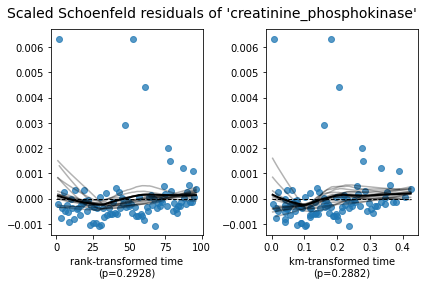

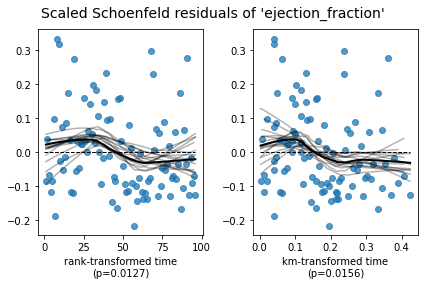

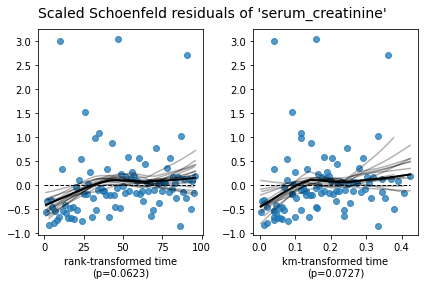

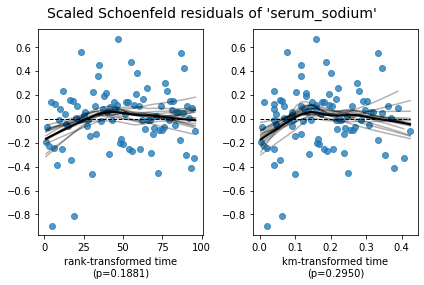

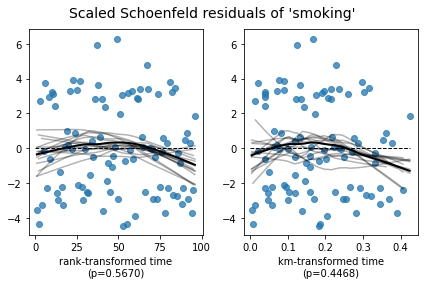

In [ ]:
model.check_assumptions(heart_data_raw, p_value_threshold = 0.5, show_plots = True)

Cabe destacar que, como en muchos otros casos, no siempre es necesario considerar demasiado si se cumlpen los supuestos o no. [Do I need to care about the proportional hazard assumption?](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Do-I-need-to-care-about-the-proportional-hazard-assumption?) brinda información relevante al respecto.

## Resumen del modelo e índice de concordancia

### Índice de concordancia

El índice de concordancia es la media de qué tan seguido el modelo dice que X es más grande que Y cuando, en los datos observados, X sí es más grande que Y.

Éste toma valores entre cero y uno donde:

- 0.5 es el resultado esperando de predicciones aleatorias.
- 1 es una concordancia perfecta y
- 0 es una concordancia anti-perfecta (multiplica las predicciones por -1 para obtener 1)

### Resumen

In [ ]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2022-01-16 23:02:39 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
age                        0.05       1.05       0.01             0.03             0.06                 1.03                 1.07
anaemia                    0.46       1.58       0.22             0.04             0.89                 1.04                 2.42
creatinine_phosphokinase   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diabetes                   0.14       1.15       0.22            -0.30             0.58                 0.74                 1.78
ejection_fraction         -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
high_blood_pressure        0.48       1.61       0.22             0.05             0.90                 1.05                 2.46
platelets                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
serum_creatinine           0.32       1.38       0.07             0.18             0.46                 1.20                 1.58
serum_sodium              -0.04       0.96       0.02            -0.09             0.00                 0.91                 1.00
sex                       -0.24       0.79       0.25            -0.73             0.26                 0.48                 1.29
smoking                    0.13       1.14       0.25            -0.36             0.62                 0.70                 1.86

                             z      p   -log2(p)
covariate                                       
age                       4.98 <0.005      20.56
anaemia                   2.12   0.03       4.89
creatinine_phosphokinase  2.23   0.03       5.26
diabetes                  0.63   0.53       0.91
ejection_fraction        -4.67 <0.005      18.35
high_blood_pressure       2.20   0.03       5.17
platelets                -0.41   0.68       0.56
serum_creatinine          4.58 <0.005      17.68
serum_sodium             -1.90   0.06       4.12
sex                      -0.94   0.35       1.53
smoking                   0.51   0.61       0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

El índice de concordancia que obtenemos, 0.74, no es malo, pero puede ser mejor. Nos indica que el modelo es mejor que una predicción aleatoria.


### Interpretación

Observando los coeficientes, ```high_blood_pressure``` tiene un coeficiente de 0.48. Esto quiere decir que un incremento de una unidad de ```high_blood_preassure```, incrementa el riesgo base por un factor de $exp(0.48) = 1.62$, un incremento del aproximado del 62%.

Ahora, para la variable ```sex``` que toma valores binarios. El valor del coeficiente asociado, $exp(-0.24)$, es el valor de la razón de riesgos asociados al sexo de la persona, esto es:

$$
0.78=exp(-0.24)=\frac{\text{riesgo de ser mujer al tiempo t}}{\text{riesgo de ser hombre al tiempo t}}
$$

Esta razón es importante porque muestra el supuesto de riesgos proporcionales. Es decir, el riesgo puede cambiar con el tiempo, pero la razón entre estos debe permanecer constante.

## Visualización de los coeficientes con intervalos de confianza

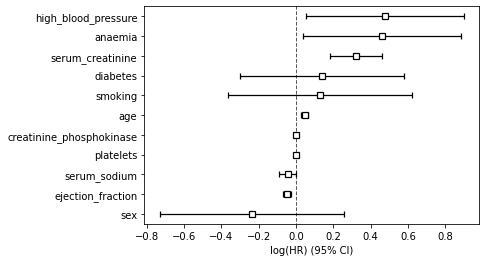

In [ ]:
model.plot()

## Curvas de supervivencia estimadas

## Riesgo acumulado

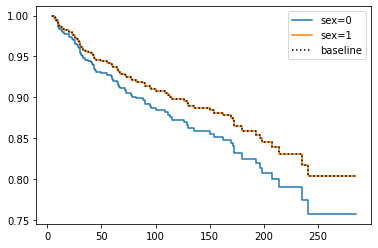

In [ ]:
model.plot_partial_effects_on_outcome('sex', values = [0, 1])

# Ejercicios

1. Siga las sugerencias de ```check_assumptions``` para obtener estimaciones de mayor potencia.

# Más al respecto

1. https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html
2. https://en.wikipedia.org/wiki/Proportional_hazards_model
3. https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator